## Adversarial Attacks Comparison Across Multiple Models
This notebook compares the effectiveness of several adversarial attacks (FGSM, PGD, CW, DeepFool) against multiple pre-trained models (ResNet50, VGG16, DenseNet121, MobileNetV2) on a subset of ImageNet data.

In [1]:
import torch
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets

from attacks.fgsm import FGSM
from attacks.pgd import PGD
from attacks.cw import CW
from attacks.deepfool import DeepFool

from utils.helpers import preprocess, set_seed, load_imagenet_classes
from utils.evaluation import evaluate_all_attacks, print_accuracy_confidence
from utils.visualization import visualize_adversarial_grid, plot_model_comparison_bar_chart

## Configuration

In [2]:
IMAGENET_VAL_DIR = './imagenet_val/'
LABEL_MAP_FILE = './imagenet_classes.txt'
BATCH_SIZE = 4     # How many images to process at once
NUM_IMAGES = 16    # Max number of images to test (keep small for quick tests)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 806

# Set random seed for reproducibility
set_seed(SEED, DEVICE)

# Check device
print(f"Using device: {DEVICE}")

Using device: cuda


### Load ImageNet Data and Class Labels

In [3]:
# Create a dataset object
imagenet_data = datasets.ImageFolder(IMAGENET_VAL_DIR, transform=preprocess)
print(f"Found {len(imagenet_data)} images in {IMAGENET_VAL_DIR}")

# Use a subset of the data
subset_indices = list(range(min(NUM_IMAGES, len(imagenet_data))))
imagenet_subset = data.Subset(imagenet_data, subset_indices)

# Create a DataLoader
test_loader = data.DataLoader(imagenet_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Created DataLoader with {len(imagenet_subset)} images.")

# Load class labels
imagenet_classes = load_imagenet_classes(LABEL_MAP_FILE)
print(f"Loaded {len(imagenet_classes)} class names from index file.")

Found 50000 images in ./imagenet_val/
Created DataLoader with 16 images.
Loaded 1000 class names from index file.


### Define Models to Test
We will test ResNet50, VGG16, DenseNet121, and MobileNetV2.

In [4]:
model_archs = {
    "ResNet50": models.resnet50,
    "VGG16": models.vgg16,
    "DenseNet121": models.densenet121,
    "MobileNetV2": models.mobilenet_v2
}

model_weights = {
    "ResNet50": models.ResNet50_Weights.IMAGENET1K_V2,
    "VGG16": models.VGG16_Weights.IMAGENET1K_V1,
    "DenseNet121": models.DenseNet121_Weights.IMAGENET1K_V1,
    "MobileNetV2": models.MobileNet_V2_Weights.IMAGENET1K_V2
}

# Store all results here
all_model_results = {}

### Define Fixed Attack Parameters

In [5]:
# FGSM
FGSM_EPSILON = 0.05

# PGD
PGD_EPSILON = 0.05
PGD_ALPHA = 0.01
PGD_STEPS = 5

# CW
CW_C = 1
CW_KAPPA = 0
CW_STEPS = 2
CW_LR = 0.01

# DeepFool
DF_STEPS = 2
DF_OVERSHOOT = 0.1
NUM_CLASSES = 1000

## Run Attacks on Each Model

In [6]:
for model_name, model_loader in model_archs.items():
    print(f"\n--- Evaluating Model: {model_name} ---")
    
    # Load pre-trained model
    print(f"Loading {model_name}...")
    current_model = model_loader(weights=model_weights[model_name])
    current_model = current_model.to(DEVICE)
    current_model.eval()
    print(f"{model_name} loaded successfully.")

    # Initialize attacks for the current model
    attacks_for_current_model = {
        'FGSM': FGSM(current_model, eps=FGSM_EPSILON),
        'PGD': PGD(current_model, eps=PGD_EPSILON, alpha=PGD_ALPHA, steps=PGD_STEPS),
        'CW': CW(current_model, c=CW_C, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR),
        'DeepFool': DeepFool(current_model, steps=DF_STEPS, overshoot=DF_OVERSHOOT, num_classes=NUM_CLASSES)
    }
    
    print(f"\nRunning attacks on {model_name}...")
    # Evaluate all attacks on the current model
    model_specific_results = evaluate_all_attacks(
        attacks_for_current_model,
        test_loader,
        current_model,
        DEVICE,
        NUM_IMAGES,
        imagenet_classes
    )
    
    all_model_results[model_name] = model_specific_results
    
    print(f"\nResults for {model_name}:")
    print_accuracy_confidence(model_specific_results, attacks_for_current_model)
    print("---------------------------------------\n")

print("\n--- All Model Evaluations Complete ---")


--- Evaluating Model: ResNet50 ---
Loading ResNet50...
ResNet50 loaded successfully.

Running attacks on ResNet50...

Starting evaluation...
  Batch 1/4: Processing 4 images...
    FGSM finished. Accuracy: 1/4
    PGD finished. Accuracy: 0/4
    CW finished. Accuracy: 1/4
    DeepFool finished. Accuracy: 1/4
  Batch 2/4: Processing 4 images...
    FGSM finished. Accuracy: 4/4
    PGD finished. Accuracy: 1/4
    CW finished. Accuracy: 3/4
    DeepFool finished. Accuracy: 4/4
  Batch 3/4: Processing 4 images...
    FGSM finished. Accuracy: 3/4
    PGD finished. Accuracy: 3/4
    CW finished. Accuracy: 1/4
    DeepFool finished. Accuracy: 3/4
  Batch 4/4: Processing 4 images...
    FGSM finished. Accuracy: 4/4
    PGD finished. Accuracy: 3/4
    CW finished. Accuracy: 2/4
    DeepFool finished. Accuracy: 3/4

Reached target number of images (16). Stopping.

Evaluation finished.

Results for ResNet50:
------------------------------
Accuracy and Average Confidence Results:
----------------

100%|██████████| 13.6M/13.6M [00:00<00:00, 17.7MB/s]


MobileNetV2 loaded successfully.

Running attacks on MobileNetV2...

Starting evaluation...
  Batch 1/4: Processing 4 images...
    FGSM finished. Accuracy: 0/4
    PGD finished. Accuracy: 0/4
    CW finished. Accuracy: 0/4
    DeepFool finished. Accuracy: 0/4
  Batch 2/4: Processing 4 images...
    FGSM finished. Accuracy: 2/4
    PGD finished. Accuracy: 0/4
    CW finished. Accuracy: 1/4
    DeepFool finished. Accuracy: 2/4
  Batch 3/4: Processing 4 images...
    FGSM finished. Accuracy: 2/4
    PGD finished. Accuracy: 0/4
    CW finished. Accuracy: 1/4
    DeepFool finished. Accuracy: 2/4
  Batch 4/4: Processing 4 images...
    FGSM finished. Accuracy: 1/4
    PGD finished. Accuracy: 0/4
    CW finished. Accuracy: 1/4
    DeepFool finished. Accuracy: 2/4

Reached target number of images (16). Stopping.

Evaluation finished.

Results for MobileNetV2:
------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 14/16 (87.50%)
C

## Overall Comparison of Models

In [7]:
attack_names = ['FGSM', 'PGD', 'CW', 'DeepFool']

print("\n--- Accuracy Comparison Across Models ---")
for model_name, results in all_model_results.items():
    clean_accuracy = (results['clean']['correct'] / results['clean']['total']) * 100
    print(f"\nModel: {model_name}")
    print(f"  Clean Accuracy: {clean_accuracy:.2f}%")

    for attack_name in attack_names:
        if attack_name in results:
            # Assuming accuracy from evaluate_all_attacks is 0-100.
            attack_accuracy = (results[attack_name]['correct'] / results[attack_name]['total']) * 100
            print(f"  {attack_name} Accuracy: {attack_accuracy:.2f}%")
        else:
            print(f"  {attack_name} Accuracy: Not available or attack failed")


--- Accuracy Comparison Across Models ---

Model: ResNet50
  Clean Accuracy: 93.75%
  FGSM Accuracy: 75.00%
  PGD Accuracy: 43.75%
  CW Accuracy: 43.75%
  DeepFool Accuracy: 68.75%

Model: VGG16
  Clean Accuracy: 87.50%
  FGSM Accuracy: 0.00%
  PGD Accuracy: 0.00%
  CW Accuracy: 6.25%
  DeepFool Accuracy: 31.25%

Model: DenseNet121
  Clean Accuracy: 93.75%
  FGSM Accuracy: 0.00%
  PGD Accuracy: 0.00%
  CW Accuracy: 18.75%
  DeepFool Accuracy: 37.50%

Model: MobileNetV2
  Clean Accuracy: 87.50%
  FGSM Accuracy: 31.25%
  PGD Accuracy: 0.00%
  CW Accuracy: 18.75%
  DeepFool Accuracy: 37.50%


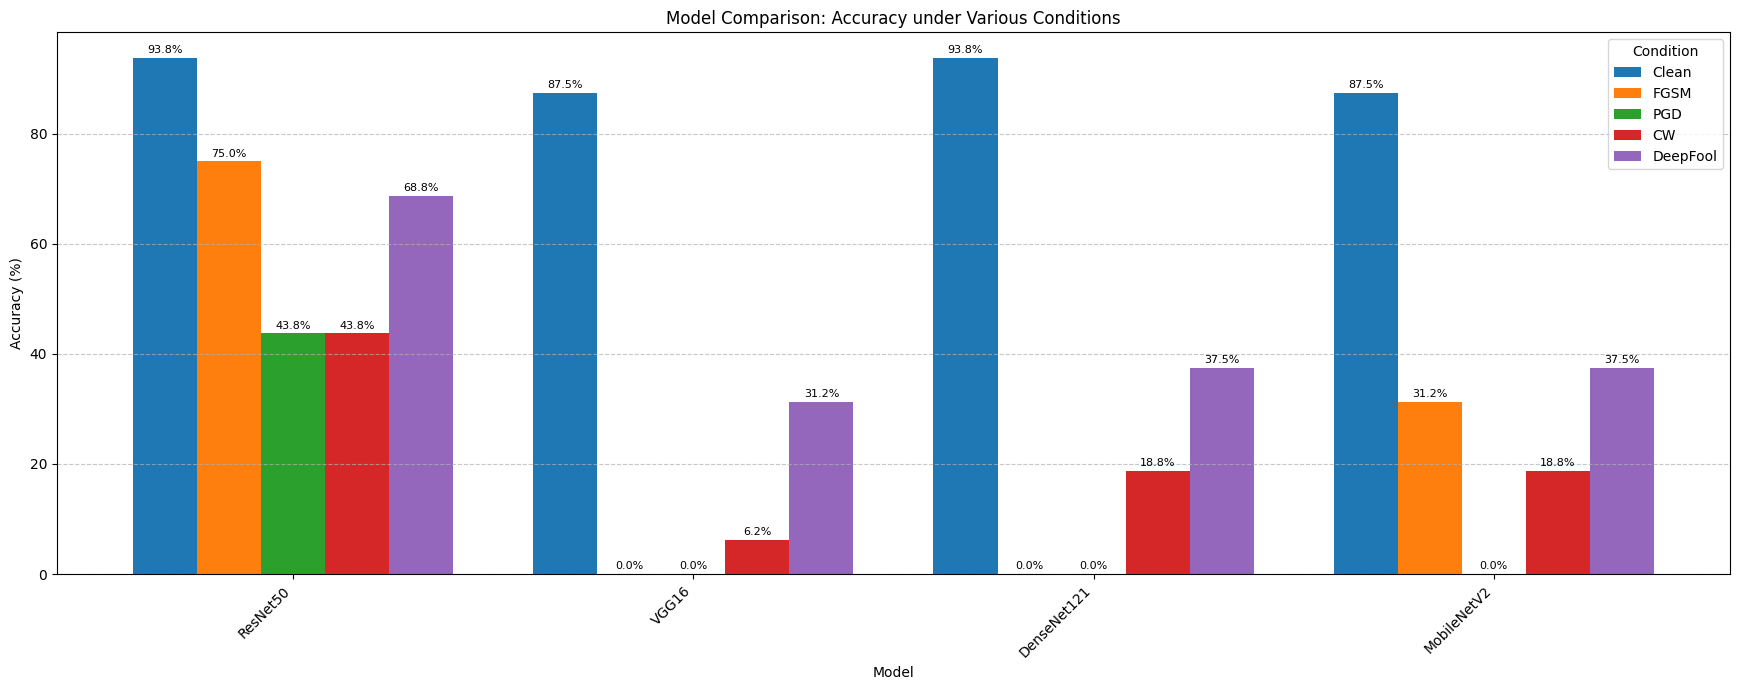

In [8]:
# Plotting the comparison
plot_model_comparison_bar_chart(all_model_results, attack_names, metric='accuracy')

## Visualize Adversarial Examples (for VGG16)

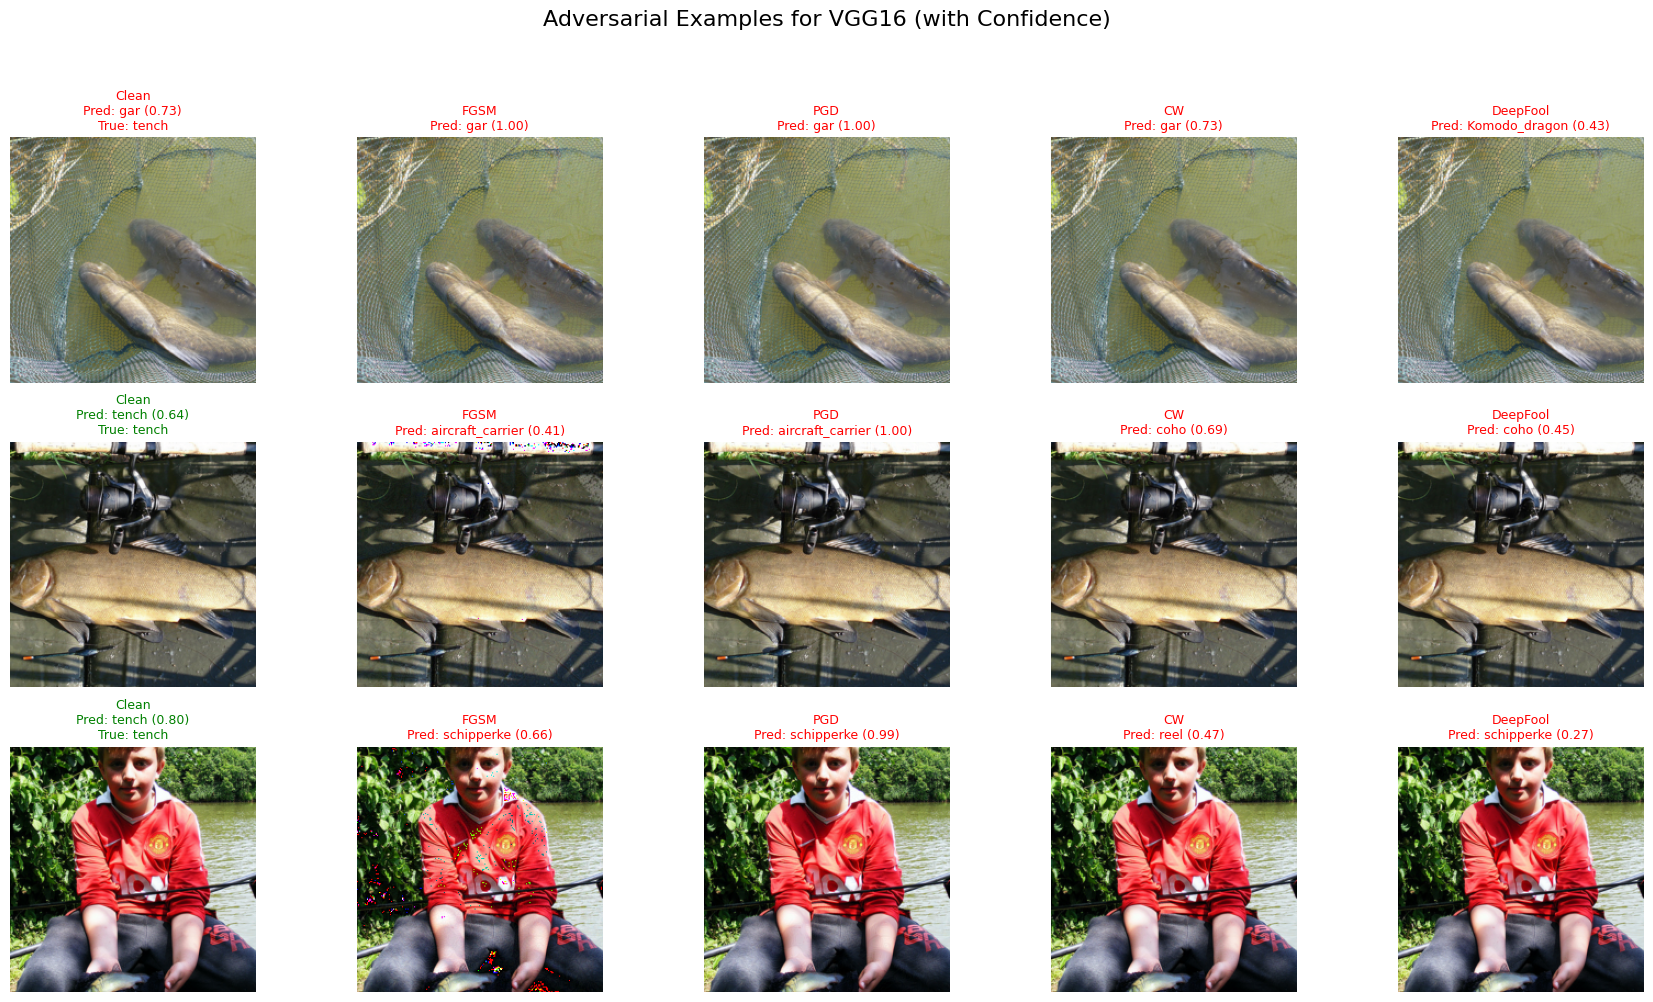

In [9]:
target_model_for_viz = "VGG16"

if target_model_for_viz in all_model_results:
    results_for_viz = all_model_results[target_model_for_viz]
    num_samples_to_show = min(3, results_for_viz['clean']['total'] if 'clean' in results_for_viz and results_for_viz['clean']['total'] > 0 else 0)

    if num_samples_to_show > 0:
        comparison_column_defs = [
            {'title_segment': attack_name, 'data_results': results_for_viz[attack_name]} 
            for attack_name in attack_names if attack_name in results_for_viz
        ]
        
        if 'clean' in results_for_viz and comparison_column_defs:
            visualize_adversarial_grid(
                num_samples_to_show=num_samples_to_show, 
                clean_data=results_for_viz['clean'], 
                column_definitions=comparison_column_defs, 
                imagenet_classes=imagenet_classes, 
                figure_suptitle=f"Adversarial Examples for {target_model_for_viz} (with Confidence)"
            )
        else:
            print(f"Not enough data or attack results to visualize for {target_model_for_viz}.")
    else:
        print(f"No clean samples to show for {target_model_for_viz}.")
else:
    print(f"Results for {target_model_for_viz} not found for visualization.")